# Synopsis

Create an LDA topic model from scratch using collapsed Gibbs Sampling.

# Configuration

In [1]:
base_path = '/Users/rca2t/COURSES/DSI/DS5559/UVA_DSI_REPO'
local_lib = base_path + '/lib'
src_dir = base_path + '/play/lda/corpora'
corpus_db = "20news.db"

In [2]:
n_docs = 100
n_topics = 10
n_iters = 100
alpha = 1
beta = 1

# Libraries

In [3]:
import pandas as pd
import numpy as np
import sqlite3
import re
import random
import sys; sys.path.append(local_lib)
import textman.textman as tx
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# Pragmas

In [4]:
%matplotlib inline

# Process

## Get corpus from database

Corpus we imported into a SQLite database earlier. We  grab a sample of N docs, as specified in the configuration.

In [5]:
sql = "SELECT * FROM doc ORDER BY RANDOM() LIMIT ?"
with sqlite3.connect(src_dir + "/" + corpus_db) as db:
    docs = pd.read_sql(sql, db, index_col='doc_id', params=(n_docs,))

### Show labels

Get a sense of what the corpus is about.

In [6]:
docs.doc_label.value_counts()

sci.crypt                   11
sci.electronics              9
comp.windows.x               9
rec.sport.hockey             9
comp.graphics                7
rec.sport.baseball           7
talk.politics.guns           7
misc.forsale                 6
talk.politics.misc           5
talk.politics.mideast        5
soc.religion.christian       4
comp.os.ms-windows.misc      4
rec.motorcycles              3
rec.autos                    3
comp.sys.ibm.pc.hardware     3
sci.space                    3
comp.sys.mac.hardware        2
alt.atheism                  2
sci.med                      1
Name: doc_label, dtype: int64

## Convert corpus to tokens and vocab

We use a function from TextMan, a bespoke library that incorporates the text processing routines used in earlier notebooks.

In [7]:
tokens, vocab = tx.create_tokens_and_vocab(docs, src_col='doc_content')
tokens['token_num'] = tokens.groupby(['doc_id']).cumcount()
tokens = tokens.reset_index()[['doc_id','token_num','term_id']]
tokens = tokens[tokens.term_id.isin(vocab[vocab.go].index)]
tokens = tokens.set_index(['doc_id','token_num'])

### We add the term strings for convenience

In [8]:
tokens['term_str'] = tokens.term_id.map(vocab.term)

In [9]:
tokens.head()

term_id term_str
doc_id token_num                  
53637  0             1647  article
       1             3478    frank
       2             7742     uucp
       3             3478    frank
       4             8144   writes

###  Remove redundant words

We actually *don't* do this because it ruins performance!

In [10]:
# tokens = tokens.reset_index().drop_duplicates(['doc_id','term_id']).set_index(['doc_id','token_num'])

In [11]:
# tokens.head()

## Remove insignificant words

We use SKlearn's TFIDF vectorizor to quicky get a TFIDF vector space, which we use only to filter the words in our corpus.

In [12]:
vectorizer = TfidfVectorizer(use_idf=1, stop_words='english', token_pattern=r'[A-Za-z][A-Za-z][A-Za-z]+')
X = vectorizer.fit_transform(docs.doc_content.values.tolist())
v = pd.DataFrame(vectorizer.get_feature_names(), columns=['term_str'])
v['idf'] = vectorizer.idf_

In [13]:
v.sort_values('idf', ascending=False).head(10)

,term_str,idf
0,aaa,4.921973
3444,pagemaker,4.921973
3451,pajise,4.921973
3450,pairs,4.921973
3449,pair,4.921973
3448,pain,4.921973
3447,paid,4.921973
3446,paging,4.921973
3445,pages,4.921973
3442,pafy,4.921973


### We take a look at the distribution of significance

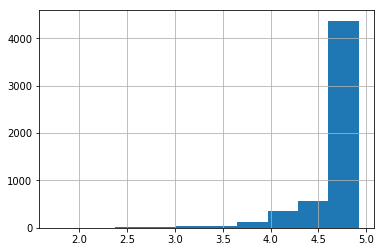

In [14]:
v.idf.hist()

### We take only the most significant words

In [15]:
v = v[v.idf > 4.5]
my_v = v.term_str.tolist()

In [16]:
tokens = tokens[tokens.term_str.isin(my_v)]

In [17]:
vocab = vocab[vocab.term.isin(my_v)]

In [18]:
tokens.head(10)

term_id   term_str
doc_id token_num                    
53637  1             3478      frank
       3             3478      frank
       6             2228      child
       7             1633   argument
       11            2626     debate
       13            6095   premises
       14            2626     debate
       24            4757     length
       46            4144  inability
       95            6930      simon

## Create topics table

We will use this to collect information about topics, and in our sampling routine.

In [ ]:
topics = pd.DataFrame(index=range(n_topics))
topics.index.name = 'topic_id'

## Define functions

### Randomly assign topics to tokens

In [ ]:
def init_topics(tokens):
    tokens['topic_id'] = np.random.randint(0, n_topics, len(tokens))
    return tokens

In [ ]:
# tokens = init_topics(tokens)

In [ ]:
# tokens.head()

### Generate Count Matrices

In [ ]:
def get_DT(tokens):
    return tokens.groupby(['doc_id','topic_id']).topic_id.count()\
        .unstack().fillna(0).astype('int')

In [ ]:
def get_WT(tokens):
    return tokens.groupby(['topic_id','term_id']).term_id.count()\
        .unstack().fillna(0).astype('int').T

In [ ]:
def get_DTP(dt):
    return (dt.T / dt.T.sum()).T

In [ ]:
def get_WTP(wt):
    wtp = wt / wt.sum()
    wtp['term_str'] = vocab.term
    wtp = wtp.set_index('term_str')
    return wtp

### Print topics

In [ ]:
def print_topics(wt, n=5):    
    wtp = get_WTP(wt)
#     wtp['term_str'] = vocab.term
#     wtp = wtp.set_index('term_str')
    for t in topics.index:
        my_topic = wtp[t]
        print('TOPIC', t,  end=': ')
        try:
            print(' '.join(my_topic.sort_values(ascending=False).head(n).index.values))
        except Exception as e:
            print("NO DICE", e)

In [ ]:
def plot_topics(wtp, n=5):
    fig, axes = plt.subplots(nrows=n_topics, ncols=1, sharex=True)
    for t in range(n_topics):
        wtp[t].sort_values(ascending=True).tail(10).plot(kind='barh', ax=axes[t], figsize=(5,80))
        axes[t].set_title('Topic {}'.format(t))

## Use Collapsed Gibbs Sampling

See [this blog](http://brooksandrew.github.io/simpleblog/articles/latent-dirichlet-allocation-under-the-hood/).

Or, better, see [Griffiths 2002](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.138.3760).

### Define row function

In [ ]:
def get_new_topic(row):
    
    d = row.name[0] # doc_id
    k = row.name[1] # token_num -- NOT USED
    z = row.topic_id
    w = row.term_id
    
    DT.at[d,z] -= 1
    WT.at[w,z] -= 1
    
    p_z = DT.loc[d] * (WT.loc[w] / WT.sum())
    z_weights = p_z / p_z.sum()

    z1 = topics.sample(weights=z_weights).index.values[0]

    DT.at[d,z1] += 1
    WT.at[w,z1] += 1
    
    return z1

### Generate model

In [ ]:
tokens = init_topics(tokens)
DT = get_DT(tokens) + alpha
WT = get_WT(tokens) + beta

In [ ]:
for i in range(n_iters):
    print(i, end=' ')
    tokens['topic_id'] = tokens.apply(get_new_topic, 1)
print('Done')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 

In [ ]:
print_topics(WT, 7)

In [ ]:
plot_topics(get_WTP(WT), 7)